Notebook for generating training and test data for the laminar (no temporal dimension) and the time periodic (with temporal dimension) navier stokes problems 
without any domain decomposition (could add to same notebook later idk)

In [1]:
import json
from pathlib import Path

import jax.numpy as np
import matplotlib.pyplot as plt
import numpy as onp

from region_utils.region import Domain, Subdomain
from region_utils.shapes import Circle, ConvexPolygon
from utils import data_path


#### Domain with matching dimensionality of problem in [DFG flow around cylinder benchmark 2D-1](https://wwwold.mathematik.tu-dortmund.de/~featflow/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark1_re20.html) 

$$\omega =[0,2.2]×[0,0.41]∖B_r(0.2,0.2)$$
$$r = 0.05$$

##### Define number of points on boundary and interior

In [2]:
n_boundary = 400
n_interior = 2100

In [3]:
#Define the vertices of the domain in clockwise order
v1 = [0,0]
v2 = [2.2,0]
v3 = [2.2, 0.41]
v4 = [0, 0.41]

domain_points = np.asarray([v1, v2, v3, v4])

#Define the cylinder and outer rectangle
Cylinder = Circle(center=np.array([0.2, 0.2]), radius=0.05, has_boundary=True)
OuterRectangle = ConvexPolygon(domain_points, list(range(4)))

In [4]:
#Define domain with subdomians
subdomain0 = Subdomain([OuterRectangle], subtraction= [Cylinder])
domain = Domain([subdomain0])

#Create boundary and interior points
domain.create_boundary(n_boundary)
domain.create_interior(n_interior, [0, 0], [2.2, 0.41])

(2076, 2)


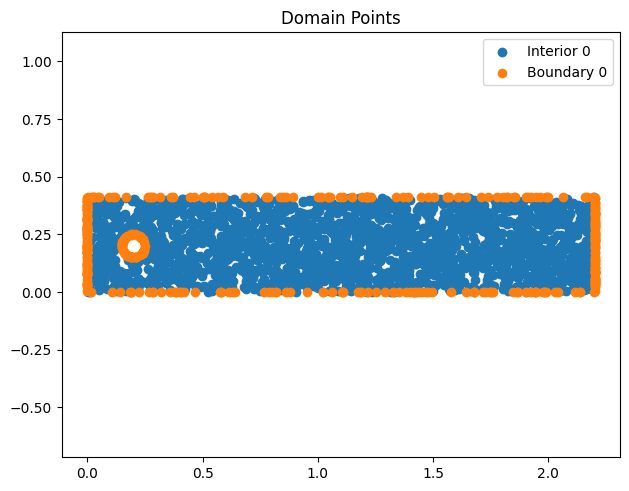

In [5]:
#Plotting the points in the domain
plt.axis("equal")

plt.tight_layout()
domain.plot()

The boundaries need to be handled differently, so we need to sort them

In [6]:
def sort_boundaries(domain_dict: dict, file: Path):
    """Sorts the boundary points in the json file and adds the 
        indices of the different boundaries to the dictionary.
        We have four different boundaries; left, wall, right and cylinder.

    Args:
        domain_dict (dict): Dictionary containing the data for the domain. Formated as domain.to_dict_format.
        file (Path): File-path for output file
    """
    
    data = domain_dict
        
    #create buckets for the different boundaries
    left_boundary = []
    wall_boundary = []
    right_boundary = []
    cylinder_boundary = []
    for p in data['XPINNs']:
        for point in p['Boundary points']:
            if np.isclose(point[0], 0):
                left_boundary.append(point)    
            elif np.isclose(point[0], 2.2):
                right_boundary.append(point)
            elif np.isclose(point[1], 0) or np.isclose(point[1], 0.41):
                wall_boundary.append(point)
            else:
                cylinder_boundary.append(point)
                
        #now we combine the buckets and note the indecies of the different boundaries
        all_boundaries = left_boundary + wall_boundary + right_boundary + cylinder_boundary
        left_boundary_index = len(left_boundary)
        wall_boundary_index = left_boundary_index + len(wall_boundary)
        right_boundary_index = wall_boundary_index + len(right_boundary)
        cylinder_boundary_index = right_boundary_index + len(cylinder_boundary)
        
        p['Boundary points'] = all_boundaries
        p['left boundary'] = left_boundary
        p['wall boundary'] = wall_boundary
        p['right boundary'] = right_boundary
        p['cylinder boundary'] = cylinder_boundary
        p['Boundary indices'] = [left_boundary_index, wall_boundary_index, right_boundary_index, cylinder_boundary_index]
    
    with open(file, "w") as outfile:
        json.dump(data, outfile)

In [7]:
domain_dict = domain.to_dict_format()


file = data_path / f"NavierStokes/single_pinn_train_{n_boundary}_{n_interior}.json"


sort_boundaries(domain_dict, file)


#### Test data

We would like to animate our solution so we generate random points in the xy plane, duplicate them and add a temporal dimention. (Not sure what resolution is sufficient)

In [8]:
domain.create_testing_data(400, v1, v3)
domain.write_to_file(data_path /"NavierStokes"/ "test_NoDecomp.json", False)

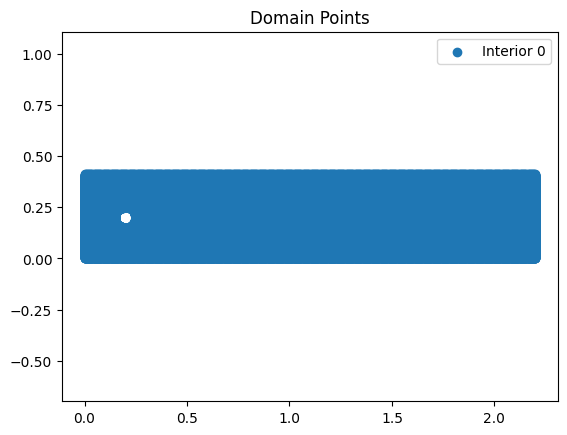

In [9]:
plt.axis("equal")
domain.plot(False)